In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader , TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision
from torch.autograd import Variable

%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def loading_whole_dataset():
    train_labels = []
    
    for i in range(1,6):
        
        batch = pd.read_pickle(f"./cifar10/data_batch_{i}")
        train_labels += batch["labels"]
        
        try:
            train_imgs = np.concatenate((train_imgs , batch["data"].reshape(-1,3,32,32)) , axis = 0)
        except:
            train_imgs = batch["data"].reshape(-1,3,32,32)
    
    train_labels = np.array(train_labels)#np.eye(10)[np.array(train_labels)] #
    
    test_batch = pd.read_pickle("./cifar10/test_batch")
    test_labels = np.array(test_batch["labels"]) #np.eye(10)[np.array(test_batch["labels"])] #
    test_imgs = test_batch["data"].reshape(-1,3,32,32)
    
    mean = train_imgs.mean()
    std = train_imgs.std()
    
    train_imgs , test_imgs = (train_imgs - mean)/std , (test_imgs - mean)/std
    
    train_labels , train_imgs = torch.tensor(train_labels) , torch.tensor(train_imgs)
    test_labels , test_imgs = torch.tensor(test_labels) , torch.tensor(test_imgs)
    
    return train_labels , train_imgs , test_labels , test_imgs , mean , std

In [4]:
train_labels , train_imgs , test_labels , test_imgs , mean , std = loading_whole_dataset()

In [5]:
train_imgs[1]

tensor([[[ 0.5190,  0.0825, -0.2449,  ..., -0.4631, -0.5254, -0.6502],
         [ 0.3007,  0.3787,  0.0669,  ..., -0.3852, -0.6813, -0.7749],
         [ 0.3007,  0.2852, -0.0890,  ..., -0.6502, -0.8216, -0.8372],
         ...,
         [ 0.8463,  0.5502,  0.5190,  ..., -1.2269, -0.9307, -0.4319],
         [ 0.6905,  0.5502,  0.5969,  ..., -0.2760,  0.0357,  0.1604],
         [ 0.6593,  0.5813,  0.6593,  ...,  0.3475,  0.3475,  0.3475]],

        [[ 0.8775,  0.2540, -0.2604,  ..., -0.4007, -0.4787, -0.6190],
         [ 0.6125,  0.5034,  0.0669,  ..., -0.3384, -0.6346, -0.7437],
         [ 0.5346,  0.3943, -0.0890,  ..., -0.6034, -0.7905, -0.8060],
         ...,
         [ 0.7216,  0.5190,  0.6125,  ..., -1.3516, -1.0555, -0.5878],
         [ 0.5190,  0.4878,  0.6281,  ..., -0.4319, -0.1046,  0.0046],
         [ 0.4254,  0.4254,  0.5502,  ...,  0.1916,  0.2072,  0.1916]],

        [[ 1.0334,  0.2384, -0.4007,  ..., -0.7749, -0.7749, -0.7905],
         [ 0.7528,  0.5190, -0.0422,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x1ec33180088>, tensor(4, dtype=torch.int32))

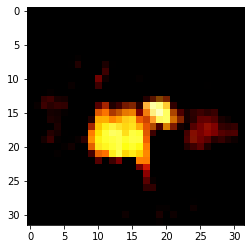

In [6]:
plt.imshow(np.transpose(train_imgs[3] , (1,2,0))) , train_labels[3]

In [7]:
# DATA ARGUMENTATION
t = [
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
    
transformations = T.Compose(t)

In [10]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors , transforms = None):
#     def __init__(self , x , y):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors#.type(torch.float).to(device)
        self.transforms = transforms#.type(torch.float).to(device)
#         self.x = x.type(torch.float).to(device)
#         self.y = y.type(torch.float).to(device)

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transforms:
            x = self.transforms(x)

        y = self.tensors[1][index]
        
        return self.x[index], self.y[index]

    def __len__(self):
        return self.tensors[0].size(0)
#         return self.x.size(0)

In [11]:
train_set = CustomTensorDataset(tensors = (train_imgs , train_labels) , transforms = transformations)
test_set = CustomTensorDataset(tensors = (test_imgs , test_labels) , transforms = transformations)

# train_set = CustomTensorDataset(train_imgs , train_labels)
# test_set = CustomTensorDataset(test_imgs , test_labels)

In [13]:
plt.imshow(np.transpose(train_set[32][0] , (1,2,0)))

TypeError: Input type float64 is not supported

In [ ]:
train_loader = DataLoader(train_set , batch_size=512 , shuffle=True)
test_loader = DataLoader(test_set , batch_size=512)

In [ ]:
def imshow(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.show()
    
for i,data in enumerate(train_loader):
    x , y = data
    imshow(torchvision.utils.make_grid(x[:16], 4), title='After Transformations')
    break

In [6]:
class CovNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3 , 32 , 7 , 1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*13*13 , 1024)
        self.fc2 = nn.Linear(1024 , 10)
        
    def forward(self , x):
        x = self.conv1(x.float())
        x = self.conv1_bn(F.relu(x))
        x = F.max_pool2d(x , 2)
        x = x.view(-1 , 32*13*13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x , dim = 1)

In [7]:
mynet = CovNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mynet.parameters() , lr = 1e-3)
mynet.to(device)

CovNet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
for i , (x,y) in enumerate(train_loader):
#     x , y = x.to(device) , y.to(device)
    print(loss_fn(mynet(x) , y.long()))
    break;

In [ ]:
def train(model , train_loader , test_loader , epoch=100 , print_every = 100):
    loss = np.zeros(epoch)
    model.train()
    for e in range(0,epoch):
            
        for i,(x,y) in enumerate(train_loader):
            x , y = x.to(device) , y.to(device)
            current_loss = loss_fn(model(x) , y.long())
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
        
        loss[e] = current_loss.item()
        if e % print_every == 0:
            print(f"Epoch : {e} | test_accuracy = {get_accuracy(model , test_loader)} | train_accuracy = {get_accuracy(model , train_loader)} | loss = {current_loss}")
            plt.cla()
            plt.plot(loss)
            plt.show()

def get_accuracy(model , data_loader):
    n_samples , n_correct = 0 , 0
    model.eval()
    with torch.no_grad():
        for i,(x,y) in enumerate(data_loader):
            x , y = x.to(device) , y.to(device)
            y_pred = torch.argmax(model(x) , dim = 1 , keepdims = False)
            n_samples += y_pred.size(0)
            n_correct += (y == y_pred).sum()
    
    return n_correct.item()/n_samples            

In [ ]:
train(mynet , train_loader , test_loader , epoch=32 , print_every=10)

In [8]:
mynet.load_state_dict(torch.load("w3.pt"))

<All keys matched successfully>

In [9]:
mynet.eval()

CovNet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
import cv2

In [18]:
img = cv2.imread("doge.jfif")
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


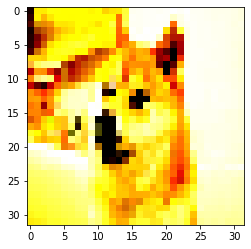

In [22]:
plt.imshow(img)

In [23]:
torch.argmax(mynet(torch.tensor([np.transpose(img , (2,0,1)) for i in range(32)]).to(device)) , dim=1 , keepdims=False)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [21]:
img = cv2.resize(img , (32,32))

In [20]:
img = (img - mean)/std

In [25]:
np.where(train_labels == 4)

(array([    3,    10,    20, ..., 49981, 49984, 49990], dtype=int64),)

In [26]:
train_labels

tensor([6, 9, 9,  ..., 9, 1, 1], dtype=torch.int32)